In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [153]:
def loadData(address):
    raw_data = np.loadtxt(address, delimiter = ',', dtype=np.str)
    data = raw_data[1:, 1:].astype(np.float)
    label = raw_data[1:, 0].astype(np.float)
    return data, label

In [154]:
train_data, train_label = loadData('./data/train.csv')

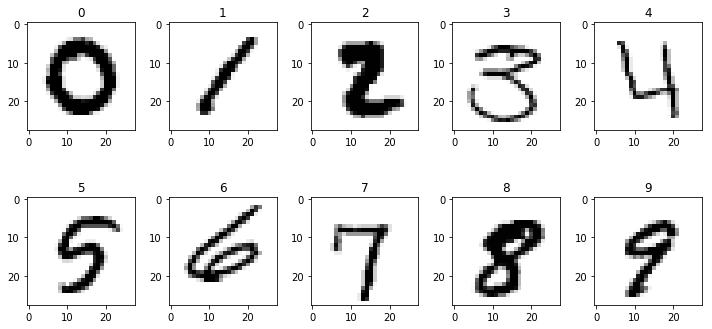

In [5]:
def digitDisplay(data, label):
    plt.figure(figsize=(10,5))
    for i in range(10):
        tmp = data[label == i, :][0].reshape((28,28))
        sub = plt.subplot(2, 5, i+1)
        sub.set_title(i)
        sub.imshow(tmp, cmap='binary')        
    plt.tight_layout()
        
digitDisplay(train_data, train_label)

In [6]:
def priorProb(label):
    # calculate the prior prob of each class
    total = label.shape[0]
    prior_prob = []
    for i in range(10):
        prior_prob.append(np.sum(label == i) / total)
    return prior_prob

In [7]:
def probHistgram(prob):
    # plot the histgram of prior prob
    plt.bar(np.arange(10), prob)
    plt.xticks(np.arange(10))
    plt.xlim(-0.5, 9.5)

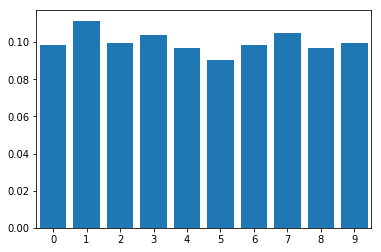

In [8]:
prob = priorProb(train_label)
probHistgram(prob)

In [9]:
def calc_distancce(data, x):
    # L2 distance
    dist = np.sqrt(np.sum((data - x) ** 2, axis=1))
    return dist

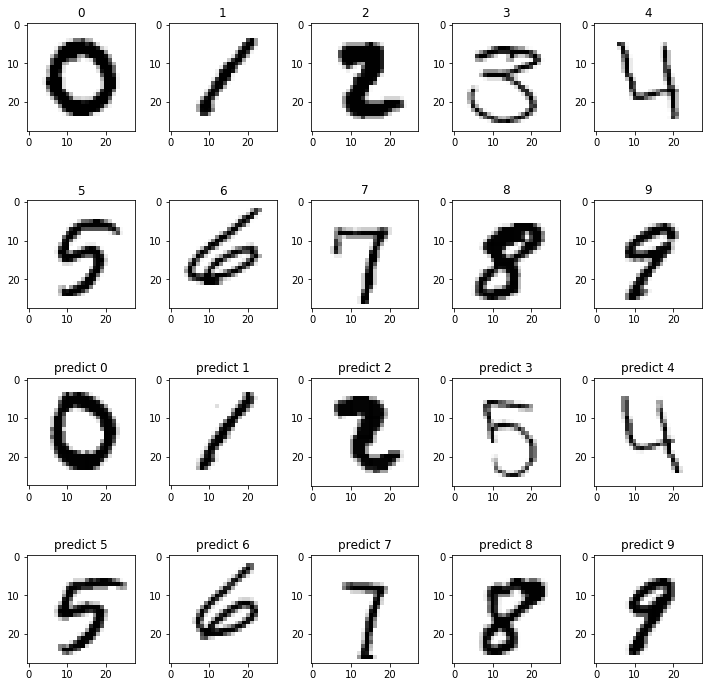

In [10]:
def naive_1NN(data, label):
    plt.figure(figsize=(10,10))
    for i in range(10):
        tmp = data[label == i, :][0]
        idx = np.argsort(calc_distancce(data, tmp), axis=0)[1]
        sub = plt.subplot(4, 5, i+1)
        sub.set_title(i)
        sub.imshow(tmp.reshape((28,28)), cmap='binary')
        sub = plt.subplot(4, 5, i+11)
        sub.set_title('predict {}'.format(i))
        sub.imshow(data[idx].reshape((28,28)), cmap='binary')
    plt.tight_layout()
        
naive_1NN(train_data, train_label)        

In [26]:
def pair_distance(x, y, data, label):
    # x and y are specific label
    data_x = data[train_label == x, :]
    data_y = data[train_label == y, :]
    genuine = []
    impostor = []
    for i in range(len(data_x)):
        genuine.extend(np.sqrt(np.sum((data_x[i] - data_x[i+1:])**2, axis=1)))
        impostor.extend(np.sqrt(np.sum((data_x[i] - data_y)**2, axis=1)))
    for i in range(len(data_y)):
        genuine.extend(np.sqrt(np.sum((data_y[i] - data_y[i+1:])**2, axis=1)))
        
    return genuine, impostor

genuine, impostor = pair_distance(0, 1, train_data, train_label)

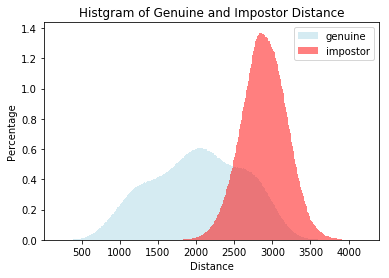

In [39]:
# Plot histograms of the genuine and impostor distances on the same set of axes.
fig, ax = plt.subplots()
bin_range = range(int(min(genuine)), int(max(impostor)) + 1, 10)
x_ = 100 * np.ones_like(genuine) / len(genuine)
y_ = 100 * np.ones_like(impostor) / len(impostor)
ax.hist(genuine, weights=x_, bins=bin_range, color="lightblue", alpha=0.5, label='genuine')
ax.hist(impostor, weights=y_, bins=bin_range, color="red", alpha=0.5, label='impostor')
ax.set(title="Histgram of Genuine and Impostor Distance", xlabel="Distance", ylabel="Percentage")
plt.legend(loc='upper right')
plt.show()

Equal Error Rate: 0.18557241682049994


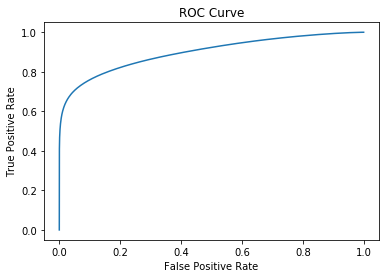

In [69]:
def ROC_curve(genuine, impostor):
    X_ = []
    Y_ = []
    genuine = np.array(genuine)
    impostor = np.array(impostor)
    for threshold in range(450, 4000, 1):
        fpr = 1.0 * np.count_nonzero(impostor < threshold) / len(impostor)
        tpr = 1.0 * np.count_nonzero(genuine < threshold) / len(genuine)
        X_.append(fpr)
        Y_.append(tpr)
        if (int((1 - tpr)*1000) == int(fpr * 1000)):
            print('Equal Error Rate:', fpr)
    plt.plot(X_, Y_)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")  
    plt.show()
    return

ROC_curve(genuine, impostor)

In [156]:
class KNN():
    
    def __init__(self, k=3):
        self.k = k
        
    def predict(self, X_train, y_train, X_test, train_flag=True):
        y_test = np.zeros(X_test.shape[0])
        
        for i in range(X_test.shape[0]):
            # [distance, label]
            dist = np.zeros((X_train.shape[0], 2))
            dist[:, 0] = calc_distancce(X_train, X_test[i])
            dist[:, 1] = y_train
            
            # get top k data points
            if train_flag:
                top_k = dist[np.argsort(dist[:, 0])][1:self.k+1]
            else:
                top_k = dist[np.argsort(dist[:, 0])][:self.k]
            top_K_count = np.bincount(top_k[:,1].astype(np.int))
#             print(top_K_count)
            y_test[i] = np.argmax(top_K_count)
        
        return y_test    

In [168]:
def calc_acc(y_train, y_test):
    return np.count_nonzero(y_train == y_test) / len(y_train)

In [182]:
# determine which k to choose
for k in range(3, 12, 2):
    start_time = time.time()
    knn = KNN(k)
    y_pred = knn.predict(train_data, train_label, train_data)
    acc = calc_acc(train_label, y_pred)
    
    print('when K = ', k, ', accuracy is ', acc, ', run-time: ', time.time() - start_time, 's.')

when K =  3 , accuracy is  0.9691904761904762 , run-time:  9688.330504894257 s.
when K =  5 , accuracy is  0.9687380952380953 , run-time:  9158.007730007172 s.
when K =  7 , accuracy is  0.9679285714285715 , run-time:  9240.558270931244 s.
when K =  9 , accuracy is  0.9668095238095238 , run-time:  9299.10688996315 s.
when K =  11 , accuracy is  0.965 , run-time:  10927.433987855911 s.


In [198]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def matrix_plot(matrix):
    plt.matshow(matrix)
    plt.colorbar()
    plt.xlabel('Predict Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[1]))
    plt.show()
    
def k_fold_cv(data, label, k, clf):
    """
    Run K-fold cross validation on specific classifier
    Args:
        data: np.array  training data
        label: np.array  label of training data
        k: int  k-fold
        clf: classifier
    Returns:
        acc: list of accuracy
        mean_acc: mean of accuracy
    """
    kf = KFold(n_splits=k,shuffle=False)
    acc = []
    i = 0
    for train_index, test_index in kf.split(data):
        # split data
        X_train = data[train_index]
        X_test = data[test_index]
        y_train = label[train_index]
        y_test = label[test_index]
        
        # run cross validation
        y_pred = clf.predict(X_train, y_train, X_test, train_flag=False)
        acc.append(calc_acc(y_test, y_pred))
        matrix = confusion_matrix(y_test, y_pred, labels=range(10))
        matrix_plot(matrix)
    print(k, ' fold cross validation accuracy: ', acc)
    mean_acc = np.mean(acc)
    print('mean accuracy: ', mean_acc)
    return acc, mean_acc

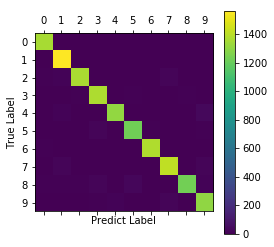

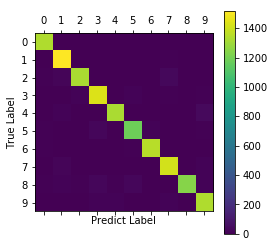

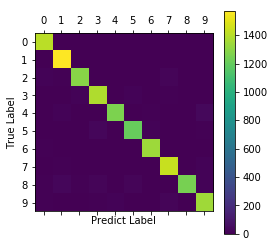

3  fold cross validation accuracy:  [0.9664285714285714, 0.9638571428571429, 0.966]
mean accuracy:  0.9654285714285713


([0.9664285714285714, 0.9638571428571429, 0.966], 0.9654285714285713)

In [199]:
knn = KNN(3)
k_fold_cv(train_data, train_label, 3, knn)

In [192]:
test_data = np.loadtxt('./data/test.csv', delimiter = ',', dtype=np.str)[1:].astype(np.float)
knn = KNN(3)
y_pred = knn.predict(train_data, train_label, test_data, train_flag=False)

In [195]:
res = np.column_stack((np.arange(1, len(y_pred) + 1), y_pred)).astype(np.int)
np.savetxt('result.csv', res, delimiter=',', fmt='%d', header='ImageId,Label', comments='')